<a href="https://colab.research.google.com/github/joelm67/Remote-Sensing-Python/blob/main/Copy_of_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Python

The purpose of this notebook is to introduce image classification concepts using Python.  In general, a supervised image classification task would include the following steps:
- define image categories/labels
- acquire remotely sensed data
- acquire training data (labels)
- extract input features based on samples
- build and test a classification model
- apply the classification model to the image to make a map
- perform accuracy assessment

Lets get started.  For this example application we will use a scene located in central Portugal.  We have several datasets to work with.  First is a generalized landcover map produced by a European colleauge.  We will use this map to derive the training/accuracy assessment samples for conveninece. Second We have Sentinel-2 MSI images acquired across three time periods in 2019: Spring, Summer, and Fall.  Each image contains six bands [blue, green, red, NIR, SWIR1, and SWIR2], all of which have been resampled to 10-meter spatial resolution.  The landcover maps the S2 images have exactly the same dimensions and have been projected to UTM Zone 29N.

In [1]:
# grab the data from a public cloud using wget
!wget https://storage.googleapis.com/alexi_daily/EnvSt956/data_for_classification.zip -O data_for_classification.zip
# unzip the contents of the zip archive
!unzip data_for_classification.zip
# clean up
!rm -rf __MACOSX/
!rm -rf sample_data
# list contents
!ls

--2021-01-25 23:12:10--  https://storage.googleapis.com/alexi_daily/EnvSt956/data_for_classification.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 74.125.143.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 336051702 (320M) [application/zip]
Saving to: ‘data_for_classification.zip’

data_for_classifica 100%[===================>] 320.48M  47.8MB/s    in 6.7s    

2021-01-25 23:12:17 (47.8 MB/s) - ‘data_for_classification.zip’ saved [336051702/336051702]

Archive:  data_for_classification.zip
  inflating: T29TNE_landcover_win.tif  
  inflating: T29TNE_label.prj        
   creating: __MACOSX/
  inflating: __MACOSX/._T29TNE_label.prj  
  inflating: T29TNE_summer_win.tif   
  inflating: T29TNE_label.dbf        
  inflating: __MACOSX/._T29TNE_label.dbf  
  inflating: T29TNE_fall_win.tif     
  inflating: T29TNE_spring_win.tif   


`T29TNE_landcover_win.tif` contains the landcover labels
`T29TNE_spring_win.tif` contains the 6-band spring image
`T29TNE_summer_win.tif` contains the 6-band summer image
`T29TNE_fall_win.tif` contains the 6-band fall image
`T29TNE_label.shp` contains a shapefile with ~5,000 samples.

The landcover labels are:
- 0  > Unclassified
- 1  > Artificial surfaces and constructions (urban and developed)
- 2  > Cultivated areas
- 3  > Vineyards
- 4  > Broadleaf tree cover
- 5  > Coniferous tree cover
- 6  > Herbaceous vegetation (grasslands)
- 7  > Moors and Heathland
- 8  > Sclerophyllous vegetation (evergreen shrub)
- 9  > Marshes
- 10 > Peatbogs
- 11 > Natural material surfaces
- 12 > Permanent snow covered surfaces
- 13 > Water bodies






Lets start the classification process by importing some important libraries

In [2]:
!add-apt-repository ppa:ubuntugis/ppa
!apt update
!apt install gdal-bin libgdal-dev
!pip3 install rasterio

 Official stable UbuntuGIS packages.


 More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
0% [1 InRelease gpgv 242 kB] [Waiting for headers] [Connecting to security.ubun
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu bionic InRelease [20.7 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64

This time we will use another library called `rasterio` to read multiband images.  Note that unlike other image processing libraries, `rasterio` reads multiband images as `<bands> <rows> <cols>`.  There are additional tools that can be used to *reshape* the array so it can be used in an image processing task.

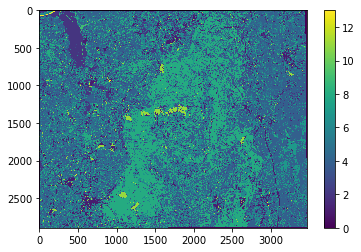

6
2897
3476


In [3]:
# import the rasterio library
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt

# read the landcover dataset
lc = rasterio.open('T29TNE_landcover_win.tif')
lcarr = lc.read(1)
#print(lcarr.shape)

plt.imshow(lcarr, vmin = 0, vmax = 13, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

# read the spring image
spring = rasterio.open('T29TNE_spring_win.tif')
sparr = spring.read()
[bands,rows,cols] = sparr.shape
print(bands)
print(rows)
print(cols)
sparr = reshape_as_image(sparr) # reshape my numpy array from <bands><rows><cols> to <rows><cols><bands>
#print('spring array: ',np.isnan(sparr).any())

# read the summer image
summer = rasterio.open('T29TNE_summer_win.tif')
suarr = summer.read()
suarr = reshape_as_image(suarr)
#print('summer array: ', np.isnan(suarr).any())

# read the fall image
fall = rasterio.open('T29TNE_fall_win.tif')
flarr = fall.read()
flarr = reshape_as_image(flarr)
#print('fall array: ',np.isnan(flarr).any())

Convert 3D numpy arrays into pandas dataframe for ease of manipulation.  First we need to reshape array as explained earlier.

In [4]:
import numpy as np
import pandas as pd

# SPRING IMAGE
# reshape the numpy array so it becomes rows*columns by band
sparr = sparr.reshape(rows*cols,bands) # collapse 3D array into a 2D array
# where the first dimension is <rows>*<cols> and second dimension is bands 
# import the data into a pandas dataframe
spdf = pd.DataFrame(sparr)
columns = ['sp_blue','sp_green','sp_red','sp_NIR','sp_SWIR1','sp_SWIR2']
spdf.columns = columns
#print(spdf)
spdf.describe()
#print(spdf.shape)
#spdf.reset_index(drop=True, inplace=True)
#print('spring: ',spdf.isnull().values.any())
#spdf.describe()

# SUMMER IMAGE
suarr = suarr.reshape(rows*cols,bands)
sudf = pd.DataFrame(suarr)
columns=['su_blue','su_green','su_red','su_NIR','su_SWIR1','su_SWIR2']
sudf.columns = columns
#print(sudf.shape)
#sudf.reset_index(drop=True, inplace=True)
#print('summer: ',sudf.isnull().values.any())
#sudf.describe()

# FALL IMAGE
flarr = flarr.reshape(rows*cols,bands)
fldf = pd.DataFrame(flarr)
columns=['fl_blue','fl_green','fl_red','fl_NIR','fl_SWIR1','fl_SWIR2']
fldf.columns = columns
#print(fldf.shape)
#fldf.reset_index(drop=True, inplace=True)
#print('fall: ',fldf.isnull().values.any())
#fldf.describe()

# LC IMAGE
lcarr = lcarr.reshape(rows*cols,1)
lcdf = pd.DataFrame(lcarr)
columns=['landcover']
lcdf.columns = columns
#print(lcdf.shape)
#lcdf.reset_index(drop=True, inplace=True)
#print('landcover: ',lcdf.isnull().values.any())
#lcdf.describe()

# axis 0 = rows
# axis 1 = columns
df = pd.concat([spdf,sudf], ignore_index=True, axis=1)
del spdf
del sudf
df = pd.concat([df,fldf],ignore_index=True, axis=1)
del fldf
df = pd.concat([df,lcdf],ignore_index=True, axis=1)
#print(df.shape)
columns = ['sp_blue','sp_green','sp_red','sp_NIR','sp_SWIR1','sp_SWIR2','su_blue','su_green','su_red','su_NIR','su_SWIR1','su_SWIR2','fl_blue','fl_green','fl_red','fl_NIR','fl_SWIR1','fl_SWIR2','landcover']
df.columns = columns
print(df)
#df = pd.concat([spdf, sudf, fldf, lcdf], ignore_index=True)

#df.describe()
df.isnull().values.any()


          sp_blue  sp_green  sp_red  ...  fl_SWIR1  fl_SWIR2  landcover
0               0         0       0  ...         0         0          0
1               0         0       0  ...         0         0          0
2               0         0       0  ...         0         0          0
3               0         0       0  ...         0         0          0
4               0         0       0  ...         0         0          0
...           ...       ...     ...  ...       ...       ...        ...
10069967        0         0       0  ...         0         0          0
10069968        0         0       0  ...         0         0          0
10069969        0         0       0  ...         0         0          0
10069970        0         0       0  ...         0         0          0
10069971        0         0       0  ...         0         0          0

[10069972 rows x 19 columns]


False

Now sample the concatanted DF to extract training data

In [5]:
from sklearn.model_selection import train_test_split

# sample 10000 rows from the DF
sample = df.sample(n=10000, random_state=1)
print(sample)

# pick X and Y variables
X = sample.drop('landcover',1)
Y = sample.landcover

# Split dataset into training set and test set [70% train 30% test]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
print(X_train.shape)
print(y_train.shape)

         sp_blue  sp_green  sp_red  ...  fl_SWIR1  fl_SWIR2  landcover
6091911      785       728     455  ...       760       307          5
921363       714       604     391  ...      1041       419          4
9081764      812       801     474  ...      1212       551          8
2221311     1069      1056     765  ...      1814       889          6
1590249      979       911     756  ...      1900      1236          6
...          ...       ...     ...  ...       ...       ...        ...
7248138     1248      1053     881  ...      2498      1691          6
3230360      828       813     490  ...      1382       583          9
8656649      848       816     590  ...      1350       676          8
9608478     1064      1147    1004  ...      1994       905          3
4006479      979       966     808  ...      1754       940          8

[10000 rows x 19 columns]
(7000, 18)
(7000,)


Now test several classifiers

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler

# first RandomForest
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
# Model Accuracy
print("RF Accuracy:",metrics.accuracy_score(y_test, y_pred))

# next XGBoost
# Fit classifier with out-of-bag estimates
params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Model Accuracy
print("XGB Accuracy:",metrics.accuracy_score(y_test, y_pred))

# now SVM
# note that SVM requires data to be scaled
cols = list(X.columns)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training set and test set [70% train 30% test]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3)

clf = svm.SVC(gamma='auto', C=100.)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Model Accuracy
print("SVM Accuracy:",metrics.accuracy_score(y_test, y_pred))


RF Accuracy: 0.615


KeyboardInterrupt: ignored

Now apply the trained model to the entire image (or the entire PD dataframe)

In [7]:
# apply RandomForest to the full DF to produce classification results
# first convert the original data 19 feature DF into a 18 feature DF by
# dropping the landcover column
# pick X and Y variables
X = df.drop('landcover',1)

# build a RF classifier and train
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

# predict class values for the full dataset
class_results = clf.predict(X)

# note that the class_results is a numpy array already with the same shape 
# as the original data <rows> * <cols>
print(class_results)
print(class_results.shape)


KeyboardInterrupt: ignored

Next, you write that numpy array into a Geotiff output image using rasterio write capabilities.  The resulting file will contain your new landcover classification results.  We will need to reshape the array into a 2D array first.

In [ ]:
print(np.unique(class_results)) # prints the unique class values
class_results = class_results.reshape(rows,cols)
print(class_results.dtype)
print(class_results.shape)

# start generating variables used for writing the geotiff image
transform = lc.transform # transform parameters read from the original image
crs = lc.crs # CRS parameters read from the original image

# write the file in one go using all options
with rasterio.open(
    'RF_results.tif',
    'w',
    driver='GTiff',
    height=class_results.shape[0],
    width=class_results.shape[1],
    count=1,
    dtype=class_results.dtype,
    crs = crs,
    transform=transform,
) as dst:
    dst.write(class_results, 1)

# check if the file exists
!gdalinfo RF_results.tif

Finally, download the file to your local computer

In [ ]:
from google.colab import files
files.download('RF_results.tif')

Here are the results displayed as color coded pixels. 

First is the original LC map.

![The original LC map](https://drive.google.com/uc?id=1vufT4iNPbRauBBPUmxTl6elJOAXJVBIP)

Second one is the RF generated LC map.

![alt text](https://drive.google.com/uc?id=17Et7JEyOjyrq-tnlCGZaKq_GBmEw4cMX)